In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
df = pd.read_csv('Monthly_oil_data.csv' , index_col='Production Date', parse_dates=True)

In [3]:
df.head()

,Volume
Production Date,
2015-01-01,67515553.0
2015-02-01,61664960.0
2015-03-01,66342950.0
2015-04-01,67719040.0
2015-05-01,66484591.0


### Train/Test Split

In [4]:
N_test = 12 
train = df.iloc[:-N_test] 
test = df.iloc[-N_test:] 

train_idx = df.index <=train.index[-1] 
test_idx = df.index > train.index[-1]

### Naive forecast

The naive forecast assumes production remains constant from one month to the next. It serves as a minimum benchmark for evaluating more advanced models. Any model that fails to outperform the naive forecast is considered ineffective.

In [5]:
df['VolumePrediction'] = df['Volume'].shift(1)

In [6]:
df.head()

,Volume,VolumePrediction
Production Date,,
2015-01-01,67515553.0,NaN
2015-02-01,61664960.0,67515553.0
2015-03-01,66342950.0,61664960.0
2015-04-01,67719040.0,66342950.0
2015-05-01,66484591.0,67719040.0


In [7]:
y_pred = df.iloc[1:]['VolumePrediction'] 
y_train_pred = y_pred.iloc[:-N_test]
y_test_pred = y_pred.iloc[-N_test:]

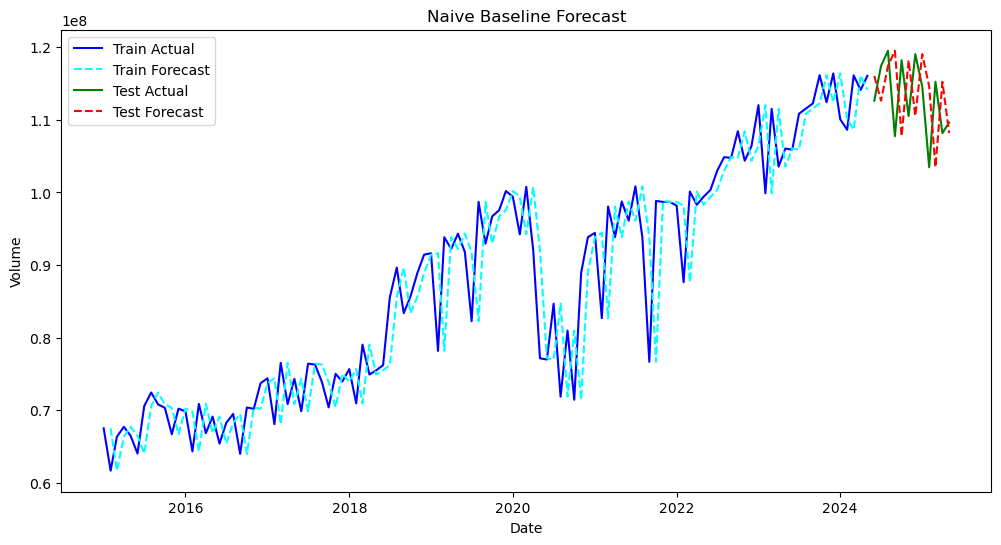

In [8]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train Actual', color='blue')
plt.plot(y_train_pred.index, y_train_pred, label='Train Forecast', color='cyan', linestyle='--')

plt.plot(test.index, test, label='Test Actual', color='green')
plt.plot(y_test_pred.index, y_test_pred, label='Test Forecast', color='red', linestyle='--')

plt.title('Naive Baseline Forecast')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend();

In [9]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'].iloc[1:], y_train_pred)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], y_test_pred)))

Train RMSE: 6673210.315199678
Test RMSE: 7925857.24523027


In [10]:
print('Train MAE:', mean_absolute_error(train['Volume'].iloc[1:], y_train_pred))
print('Test MAE:', mean_absolute_error(test['Volume'], y_test_pred))

Train MAE: 4934792.116071428
Test MAE: 7054035.166666667


In [11]:
print('Train R2:', r2_score(train['Volume'].iloc[1:], y_train_pred))
print('Test R2:', r2_score(test['Volume'], y_test_pred))

Train R2: 0.8185829554155855
Test R2: -1.5741518437989686


### EWMA

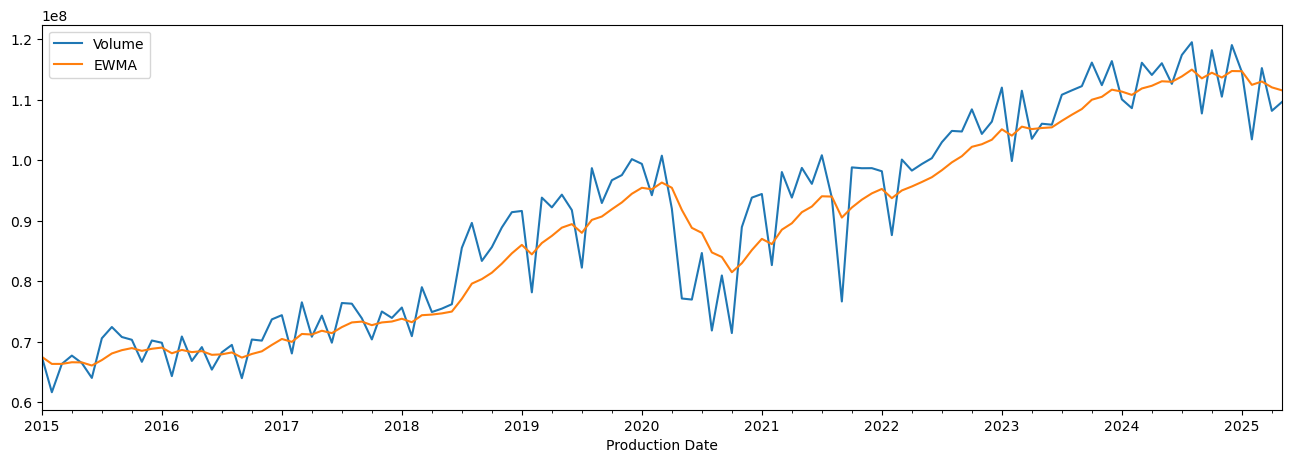

In [12]:
alpha = 0.2
df['EWMA'] = df['Volume'].ewm(alpha = alpha, adjust=False).mean() 
df[['Volume', 'EWMA']].plot(figsize=(16,5));

In [13]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], df['EWMA'].iloc[:-N_test])))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], df['EWMA'].iloc[-N_test:])))

Train RMSE: 4937168.763025521
Test RMSE: 4224877.291323939


In [14]:
print('Train MAE:', mean_absolute_error(train['Volume'],  df['EWMA'].iloc[:-N_test]))
print('Test MAE:', mean_absolute_error(test['Volume'], df['EWMA'].iloc[-N_test:]))

Train MAE: 3975626.419578446
Test MAE: 3548693.139170397


In [15]:
print('Train R2:', r2_score(train['Volume'],  df['EWMA'].iloc[:-N_test]))
print('Test R2:', r2_score(test['Volume'],df['EWMA'].iloc[-N_test:]))

Train R2: 0.9012324305917702
Test R2: 0.26857488432689725


### SES

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

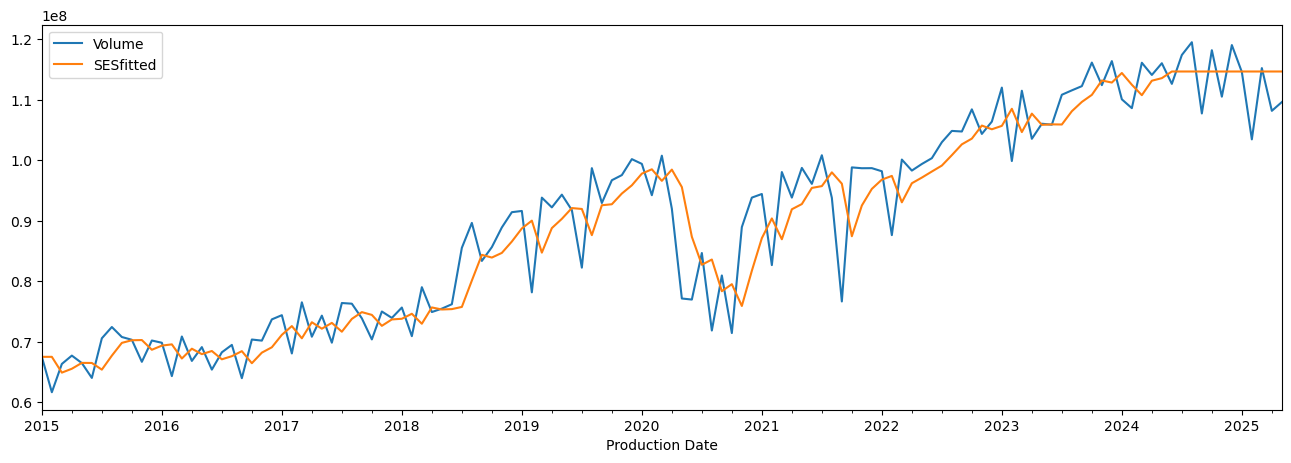

In [17]:
df.index.freq = 'MS'  

N_test = 12 
train = df.iloc[:-N_test] 
test = df.iloc[-N_test:] 

train_idx = df.index <=train.index[-1] 
test_idx = df.index > train.index[-1]

ses = SimpleExpSmoothing(train['Volume'], initialization_method='legacy-heuristic') 
res = ses.fit() 

df.loc[train_idx, 'SESfitted'] = res.fittedvalues 
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Volume', 'SESfitted']].plot(figsize=(16,5));

In [18]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res.forecast(N_test))))

Train RMSE: 5701867.165526608
Test RMSE: 5213051.49486047


In [19]:
print('Train MAE:', mean_absolute_error(train['Volume'], res.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res.forecast(N_test)))

Train MAE: 4355431.18347914
Test MAE: 4335954.4991718875


In [20]:
print('Train R2:', r2_score(train['Volume'], res.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res.forecast(N_test)))

Train R2: 0.8682675976238147
Test R2: -0.11359096728501483


### Holt

In [21]:
from statsmodels.tsa.holtwinters import Holt

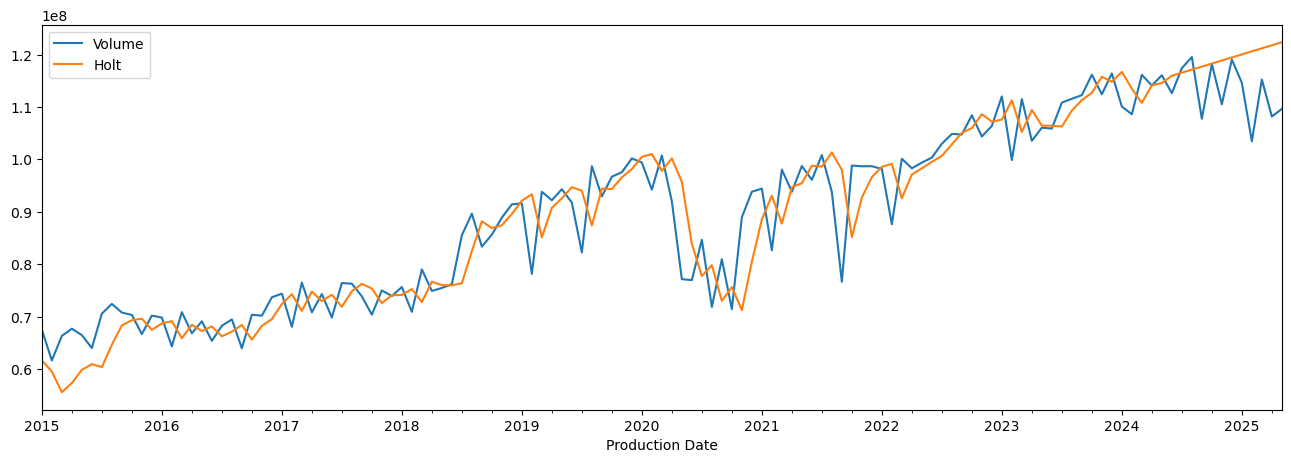

In [22]:
holt = Holt(train['Volume'], initialization_method='legacy-heuristic') 
res_h = holt.fit() 

df.loc[train_idx, 'Holt'] = res_h.fittedvalues
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)
df[['Volume', 'Holt']].plot(figsize=(16,5));

In [23]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res_h.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res_h.forecast(N_test))))

Train RMSE: 6273553.925687219
Test RMSE: 8624220.889348267


In [24]:
print('Train MAE:', mean_absolute_error(train['Volume'], res_h.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res_h.forecast(N_test)))

Train MAE: 4685423.638309482
Test MAE: 6686203.897389203


In [25]:
print('Train R2:', r2_score(train['Volume'], res_h.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res_h.forecast(N_test)))

Train R2: 0.8405275406378807
Test R2: -2.0477645450060793


### Holt-Winters

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Additive Trend + Seasonality

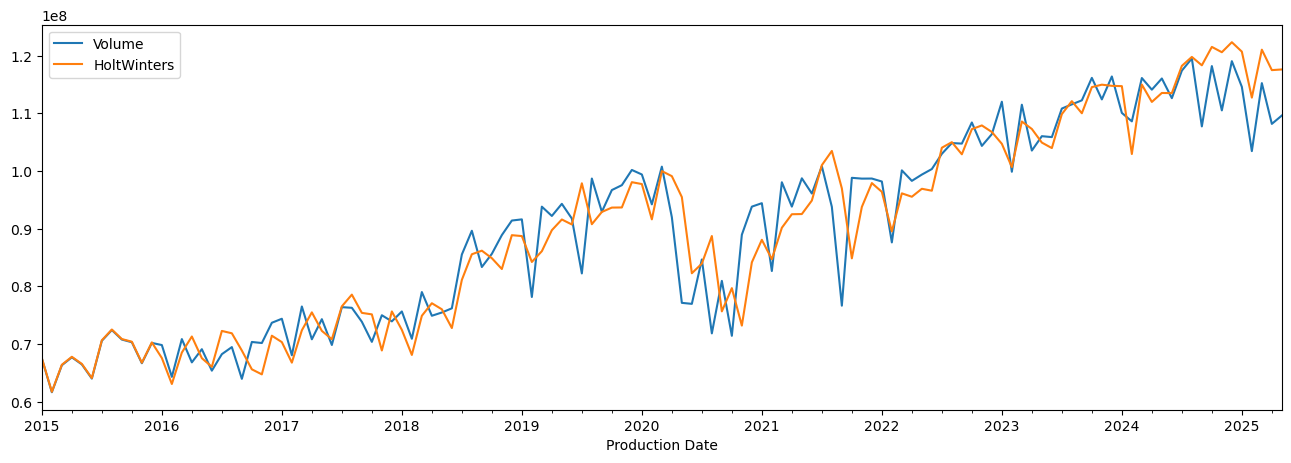

In [27]:
hw = ExponentialSmoothing(train['Volume'], initialization_method='legacy-heuristic',
                         trend='add', seasonal='add', seasonal_periods=12) 
res_hw = hw.fit() 
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues 
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test) 
df[['Volume', 'HoltWinters']].plot(figsize=(16,5));

In [28]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res_hw.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res_hw.forecast(N_test))))

Train RMSE: 5255490.723052157
Test RMSE: 6737046.936829787


In [29]:
print('Train MAE:', mean_absolute_error(train['Volume'], res_hw.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res_hw.forecast(N_test)))

Train MAE: 3528012.8620291688
Test MAE: 5643690.092431731


In [30]:
print('Train R2:', r2_score(train['Volume'], res_hw.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res_hw.forecast(N_test)))

Train R2: 0.8880858582068198
Test R2: -0.8598624054886452


#### Multiplicative Seasonality

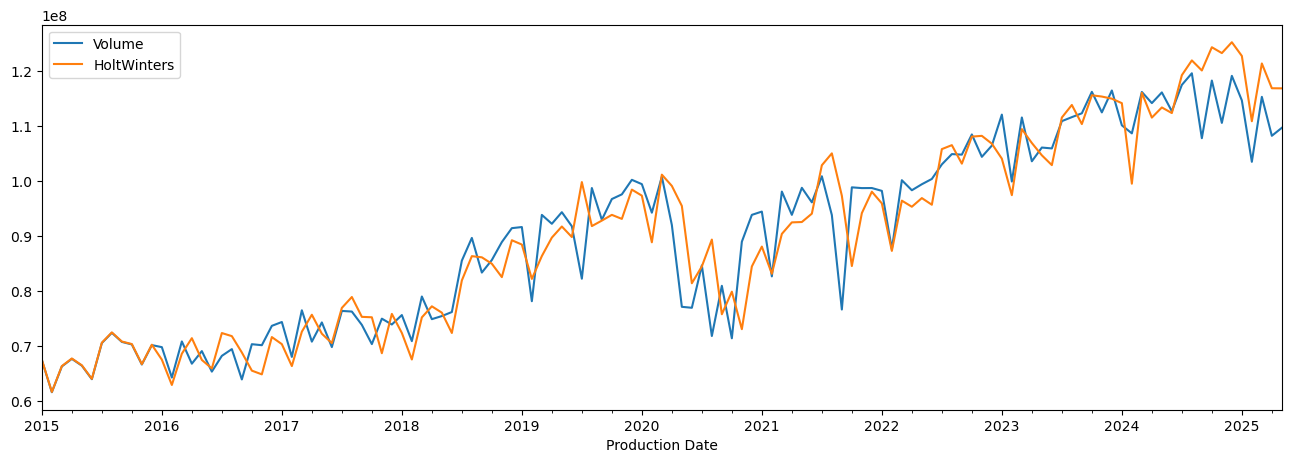

In [31]:
hw = ExponentialSmoothing(train['Volume'], initialization_method='legacy-heuristic',
                         trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit() 
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues 
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test) 
df[['Volume', 'HoltWinters']].plot(figsize=(16,5));

In [32]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res_hw.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res_hw.forecast(N_test))))

Train RMSE: 5417331.692961109
Test RMSE: 7501740.074637253


In [33]:
print('Train MAE:', mean_absolute_error(train['Volume'], res_hw.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res_hw.forecast(N_test)))

Train MAE: 3635092.844755321
Test MAE: 6566245.667440371


In [34]:
print('Train R2:', r2_score(train['Volume'], res_hw.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res_hw.forecast(N_test)))

Train R2: 0.8810870164080752
Test R2: -1.3060339372191443


#### Multiplicative Trend + Seasonality

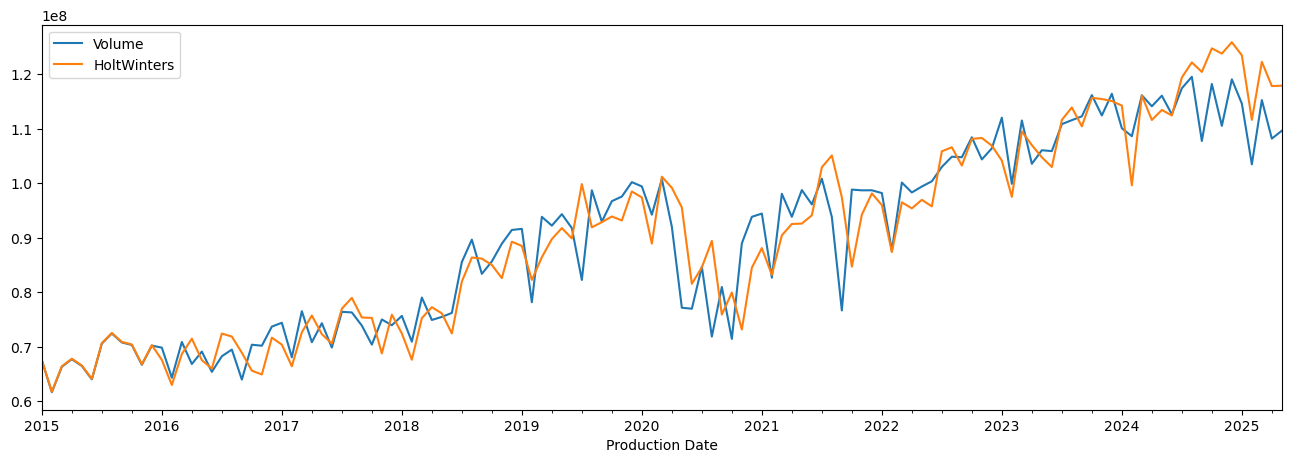

In [35]:
hw = ExponentialSmoothing(
    train['Volume'], initialization_method='legacy-heuristic', trend='mul',
    seasonal='mul', seasonal_periods=12) 
res_hw = hw.fit() 
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Volume', 'HoltWinters']].plot(figsize=(16,5));

In [36]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res_hw.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res_hw.forecast(N_test))))

Train RMSE: 5413625.406644346
Test RMSE: 8120349.211561042


In [37]:
print('Train MAE:', mean_absolute_error(train['Volume'], res_hw.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res_hw.forecast(N_test)))

Train MAE: 3621779.8821385945
Test MAE: 7167787.927894617


In [38]:
print('Train R2:', r2_score(train['Volume'], res_hw.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res_hw.forecast(N_test)))

Train R2: 0.8812496702114527
Test R2: -1.7020356967663726


_EWMA achieves the lowest training RMSE, indicating the best in-sample fit.
This is followed by the Holt–Winters model with additive seasonality, while the Naive Forecast shows the highest training error_

_EWMA again records the lowest test RMSE, demonstrating strong generalization to unseen data.
The Simple Exponential Smoothing (SES) model performs second best, whereas the Holt model yields the highest test RMSE._